**Importing Essential libraries**


In [ ]:
import numpy as np
import operator
import multiprocessing 
import time
import math 

**Main Blast Methods**

**Blast_multiprocessing()** - This is the main BLAST function with is called first, this function divides the BLAST computation into different processes. Each indivisual BLAST on a database sequence is done on a different process.

**blast_per_seq()** - This function applies the BLAST algorithm on the between the query sequence and the specified Database Genome sequence.


**Optimization** - Multiprocess is allowing us to have almost 5 times the computation speed.
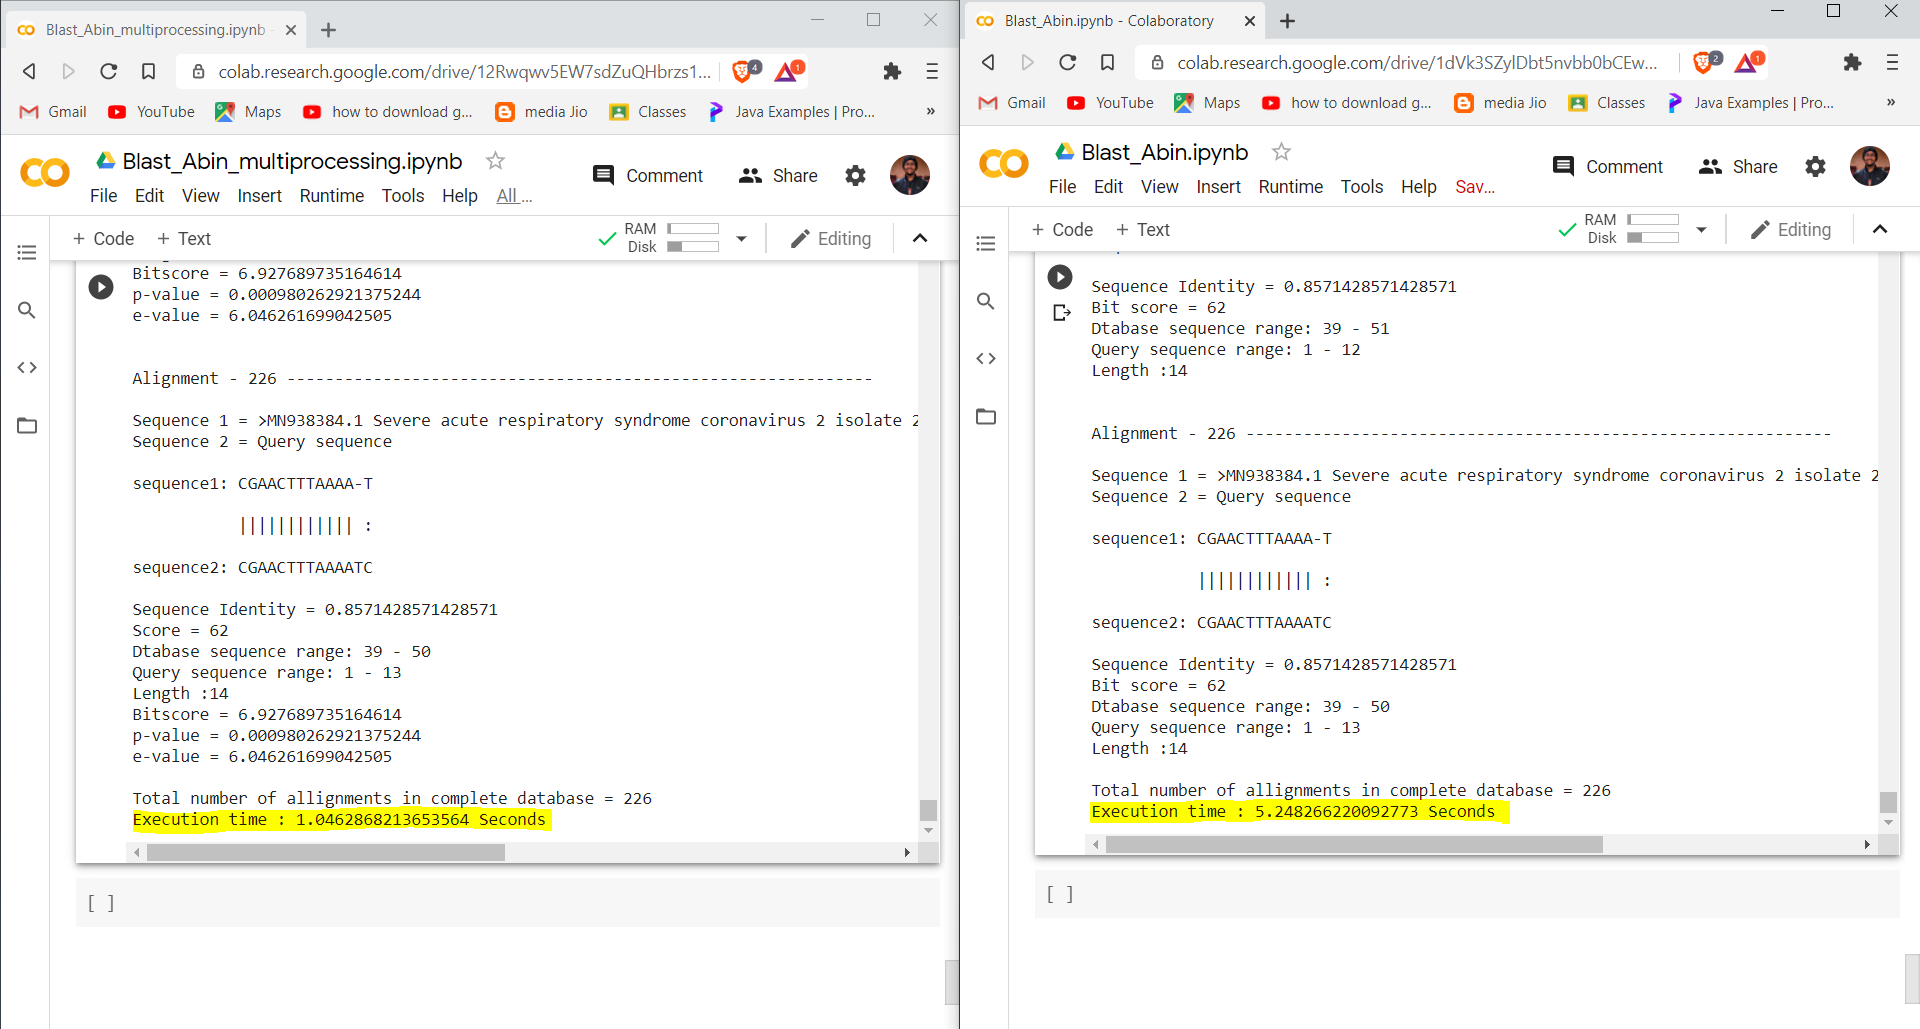

In [ ]:

# This is the main BLAST function with is called first, this function divides the BLAST computation into different processes. 
# Each indivisual BLAST on a database sequence is done on a different process.
def Blast_multiprocessing(query_seq, database_seqs, w, match, mismatch, gap, extension_threshold, hssp_threshold, names):
	processes = []
	manager = multiprocessing.Manager()
	return_dict = manager.dict()
	for i in names:
		p = multiprocessing.Process(target=blast_per_seq, args=(query_seq, database_seqs, w, match, mismatch, gap, extension_threshold, hssp_threshold, names, i, return_dict))

		processes.append(p)

	for i in processes:
		i.start()

	for p in processes:
		p.join()

	total_alignments = 0
	complete_output = ""

	for name in names:

		output = return_dict.get(name)
		total_alignments += output.count("Alignment")
		complete_output += output

	i = 0
	count = 1
	ind = complete_output.find("Alignment",i)
	while(ind != -1):
		ind2 = complete_output.find("--",ind)
		complete_output = complete_output[:ind] + "Alignment - " + str(count) + " " + complete_output[ind2:]
		i = ind+1
		ind = complete_output.find("Alignment",i)
		count+=1

	print(complete_output)
	print("Total number of allignments in complete database = " + str(total_alignments))


# This function applies the BLAST algorithm on the between the query sequence and the specified Database Genome sequence.
def blast_per_seq(query_seq, database_seqs, w, match, mismatch, gap, extension_threshold, hssp_threshold, names, i, return_dict):
	db_seq_name = i 
	database_seq = database_seqs[i]
	words_seq = []

	db_seq_len = len(database_seq)
	qry_len = len(query_seq)

	frag_start_db_arr = fragment_db_sequence(database_seq, db_seq_len, w)

	frag_start_query_arr = fragment_query_sequence(query_seq, qry_len, w, hssp_threshold)

	hssp_pairs = find_hssp_pairs( frag_start_query_arr, frag_start_db_arr)

	seed_output = find_seed(query_seq, database_seq, hssp_pairs, w)
	max_length = [0]
	ali_count = [1]
	output = []
	total_alignments = [0]
	score_freq = {}
	for seed in seed_output:
		SMalignment(seed[3], seed[2], match, mismatch, gap, extension_threshold, db_seq_name, seed[0], seed[1], ali_count, max_length, output, total_alignments, score_freq)
	
	total_alignments2 = [qry_len*db_seq_len - (qry_len*(qry_len+1))//2]

	temp_score_arr = []
	for j in score_freq:
		temp_score_arr.append([j, score_freq[j]])
	temp_score_arr = sorted(temp_score_arr, key = lambda x:x[0])
	l = len(temp_score_arr)
	s = 0
	for index in range(l-1,-1,-1):
		s+=temp_score_arr[index][1]
		score_freq[temp_score_arr[index][0]] = s
	l = len(output)


	for k in range(l):
		out = output[k]

		s = int(out[5][out[5].find("= ")+2:-1])
		# print(score_freq[s], s)
		nume = score_freq[s]
		pvalue = nume/total_alignments2[0]
		evalue = total_alignments[0]*pvalue
		bitscore = math.log((total_alignments[0])/evalue)
		out.append("Bitscore = " + str(bitscore) + "\n")
		out.append("p-value = " + str(pvalue) + "\n")
		out.append("e-value = " + str(evalue) + "\n")

	output_string = ""


	for arr in range(l):

		for ind in range(len(output[arr])):
			output_string+=output[arr][ind]

	print(i)
	return_dict[i] = output_string

	return return_dict



**Fragmentation and Pre Processing**

**fragment_db_sequence()** - This is a pre-processing function which breaks the database Genome sequence provided to the function to it's 'W' lengthed words mapping them to their starting positions in the database genome sequence. It returns a sorted array, sorted on the basis of the number representations of the words so that Binary Search can be applied.

**fragment_query_sequence()** - This function query sequence breaks the query sequence into 'W' lengthed words

**get_neighbours** - This function finds all the neighbours of the query word with matching score > hssp_threshold


In [14]:
# This function is used to get the number representation of the nucleotide sequence 
def WordToNum(word):
    tmp = []
    trans = {'A':1,'C':2,'G':3,'T':4}
    for w in word:
        tmp.append(trans[w])
    return tmp

# This function transforms evaluates the index of the number representation of the nucleotide sequence
def WordToIndex(word,word_len):
    tmp = 0
    word_num = WordToNum(word)
    for i,v in enumerate(word_num):
        tmp += (v-1)*(4**(word_len-i-1))
    return tmp   


# This is a pre-processing function which breaks the database Genome sequence provided to the function to it's 'W' lengthed words mapping them to their 
# starting positions in the database genome sequence. It returns a sorted array, sorted on the basis of the number representations of the words so that Binary Search can be applied.
def fragment_db_sequence(database_seq, db_seq_len, w):
	frag_start_dict = {}

	i = 0
	while(i+w-1<db_seq_len):
		word = database_seq[i:i+w]
		word_index = WordToIndex(word, w)
		if(frag_start_dict.get(word_index) != None):
			frag_start_dict[word_index].append(i)
		else:
			frag_start_dict[word_index] = [i]
		i+=1

	frag_start_arr = []
	for j in frag_start_dict:
		frag_start_arr.append([j, frag_start_dict[j]])
	frag_start_arr = sorted(frag_start_arr, key = lambda x:x[0])

	return frag_start_arr



# This function query sequence breaks the query sequence into 'W' lengthed words
def fragment_query_sequence(query_seq, qry_len, w, hssp_threshold):
	match = 5
	mismatch = -4
	index_arr = []
	i = 0

	query_frags = []
	while(i+w-1<qry_len):
		word = query_seq[i:i+w]
		neighbours = set([])
		get_neighbours(word, w, match, mismatch, 0, match*w, neighbours, hssp_threshold)
		neighbours = list(neighbours)
		for j in neighbours:
			query_frags.append([ WordToIndex(j,w),i])
		i+=1
	return query_frags


# This function finds all the neighbours of the query word with matching score > hssp_threshold
def get_neighbours(word, w, match, mismatch, i, score, neighbours, hssp_threshold):
	if(score<hssp_threshold or i==w):
		return

	neighbours.add(word)

	residues = ["A","T","G","C"]

	for r in residues:
		if(r!=word[i]):
			neighbour_word = word[:i] + r + word[i+1:]
			get_neighbours(neighbour_word, w, match, mismatch, i+1, score-match+mismatch, neighbours, hssp_threshold)

	get_neighbours(word, w, match, mismatch, i+1, score, neighbours, hssp_threshold)




**Aligning words and finding combining adjacent matched HSSPs**

**binary_search_in_seq()** - Binary search on the given database genome sequence for matching query word.

**find_hssp_pairs()** - Main method which calls binary search for all query words. Finding HSSP pairs between the query and the db_sequence words

**find_seed()** - Creating the union of all the adjacent matched words.

In [ ]:
# Binary search on the given database genome sequence for matching query word.
def binary_search_in_seq(word, frag_start_db_arr, l, r):
	# Check base case
	if r >= l:

		mid = l + (r - l) // 2

		if frag_start_db_arr[mid][0] == word[0]:
			return frag_start_db_arr[mid][1]

		elif frag_start_db_arr[mid][0] > word[0]:
			return binary_search_in_seq(word, frag_start_db_arr, l, mid-1)
		else:
			return binary_search_in_seq(word, frag_start_db_arr, mid+1, r)
	else:
		return []


# Finding HSSP pairs between the query and the db_sequence words
def find_hssp_pairs( frag_start_query_arr, frag_start_db_arr):

	hssp_pairs = []
	for word in frag_start_query_arr:
		matching_starting_positions = binary_search_in_seq(word, frag_start_db_arr, 0, len(frag_start_db_arr)-1)

		if(matching_starting_positions != []):
			for i in matching_starting_positions:
				hssp_pairs.append([word[1], i])
	return hssp_pairs


# This is function to find all the seeds from the exact gapped matches length equal to the world length
# The output is the span of the possible union of seeds in a form of a 2D list  
def find_seed(query_seq, database_seq, start_list, w):
    new_list = []
    for i in start_list:
        for j in range(1, w):
            n = [i[0]+j, i[1]+j]
            if(n not in new_list and n not in start_list):
                new_list.append(n)

    coord_list = start_list + new_list

    MatrixPos = np.full([len(query_seq), len(database_seq)], 0, dtype=int)
    for curr_coord in coord_list:
        MatrixPos[curr_coord[0]][curr_coord[1]] = 1

    visited = np.full([len(query_seq), len(database_seq)], 0, dtype=int)

    seed_collection = []
    seed_range = []
    total_seeds = 0

    for curr_coord in start_list:
        i, j = curr_coord
        curr_seed = []
        if(MatrixPos[i][j] == 1 and visited[i][j] == 0):
            dfs(MatrixPos, i, j, visited, curr_seed, database_seq)
            total_seeds += 1
        # print(curr_seed)
        if(len(curr_seed) > 0):
            x_min = curr_seed[0][0]
            x_max = curr_seed[len(curr_seed)-1][0]
            y_min = curr_seed[0][1]
            y_max = curr_seed[len(curr_seed)-1][1]

            sub_query_seq = query_seq[x_min:x_max+1]
            sub_database_seq = database_seq[y_min:y_max+1]
            seed_collection.append(curr_seed)
            seed_range.append([[x_min, x_max], [y_min, y_max],
                               sub_query_seq, sub_database_seq])

    # print((seed_collection))
    # print(seed_range)
    return seed_range		


# function to check if the neighbours are correct consideration for DFS
def check(MatrixPos, i, j, visited, database_seq):
    return (i >= 0 and i < len(query_seq) and j >= 0 and j < len(database_seq) and (not visited[i][j] and MatrixPos[i][j] == 1))


# dfs for finding the seeds
def dfs(MatrixPos, i, j, visited, curr_seed, database_seq):
	# checking the right, down and diagonally right blocks
    row_next = [1, 0, 1]
    col_next = [0, 1, 1]
    visited[i][j] = 1
    curr_seed.append([i, j])

    for k in range(3):
        if(check(MatrixPos, i + row_next[k], j + col_next[k], visited, database_seq)):
            dfs(MatrixPos, i + row_next[k], j + col_next[k], visited, curr_seed, database_seq)




**Applying the Smith- Waterman algoithm on the small region of extended/union of adjacent words**

**SMalignment()** - Smith–Waterman Alignment on the unions of the neighbouring matching words.

**backtracking()** - This function applies backtracking from the cells which have a score greater than the Extension threshold valus.

In [ ]:
# Smith–Waterman Alignment on the unions of the neighbouring matching words
def SMalignment(seq1, seq2, match, mismatch, g, extension_threshold, db_seq_name, query_range, database_range, ali_count, max_length, output, total_alignments, score_freq):
    m = len(seq1)
    n = len(seq2)
    # print(seq1)
    # print(seq2)
    matrix = []

    for i in range(0, m):
        tmp = []
        for j in range(0, n):
            tmp.append(0)
        matrix.append(tmp)
    for sii in range(0, m):
        matrix[sii][0] = sii*g
    for sjj in range(0, n):
        matrix[0][sjj] = sjj*g

    maxx_score = 0
    starting_point = []
    starting_point_visited = {}

    for siii in range(1, m):
        for sjjj in range(1, n):
            matrix[siii][sjjj] = max(matrix[siii-1][sjjj] + g, matrix[siii - 1][sjjj - 1] + SingleBaseCompare(seq1,seq2,siii, sjjj, match, mismatch), matrix[siii][sjjj-1] + g)
            if(score_freq.get(matrix[siii][sjjj]) == None):
            	score_freq[matrix[siii][sjjj]] = 1
            else:
            	score_freq[matrix[siii][sjjj]] += 1
            total_alignments[0] += 1
            if(matrix[siii][sjjj] >= extension_threshold):
            	tup = (siii,sjjj, matrix[siii][sjjj])
            	starting_point.append(tup)
            	starting_point_visited[(tup[0], tup[1])] = False


    starting_point = sorted(starting_point, key = lambda x:(x[0], x[1]))
    l = len(starting_point)


    for j in range(l-1,-1,-1):
    	i = starting_point[j]
    	if(not(starting_point_visited[(i[0],i[1])])):
    		temp = []
    		a = backtracking(i[0], i[1], seq1, seq2, matrix, starting_point_visited)
    		temp.append("\n")
    		temp.append("\n")
    		temp.append("Alignment - " + str(ali_count[0]) + " -------------------------------------------------------------\n" )
    		ali_count[0]+=1
    		disp = Display(a[0], a[1], db_seq_name)
    		temp.append(disp + "\n")
    		temp.append("Sequence Identity = " + str(a[2]) + "\n")
    		temp.append("Score = " + str(i[2]) + "\n")
    		temp.append("Dtabase sequence range: " + str(database_range[0] + a[3]) + " - " + str(database_range[0] + a[5]) + "\n")
    		temp.append("Query sequence range: " + str(query_range[0] + a[4]) + " - " + str(query_range[0] + a[6]) + "\n")
    		temp.append("Length :" + str(len(a[0])) + "\n")
    		max_length[0] = max(max_length[0], len(a[0]))
    		output.append(temp)


# compare single base
def SingleBaseCompare(seq1,seq2,i,j, match, mismatch):
    if seq1[i] == seq2[j]:
        return match
    else:
        return mismatch

# Backtracking on the Smith Waterman matrix from the points having score greater than the extension threshold
def backtracking(m, n, seq1, seq2, matrix, starting_point_visited):
	sequ1 = [seq1[m-1]]
	sequ2 = [seq2[n-1]]

	ending_seq1 = m-1
	ending_seq2 = n-1
	starting_seq1 = m-1
	starting_seq2 = n-1
	while m > 1 and n > 1:
		if max(matrix[m-1][n-2], matrix[m-2][n-2], matrix[m-2][n-1]) == matrix[m-2][n-2]:
			m -= 1
			n -= 1
			if(starting_point_visited.get((m,n)) != None):
				starting_point_visited[(m,n)] = True

			starting_seq1 = m
			starting_seq2 = n

			sequ1.append(seq1[m-1])
			sequ2.append(seq2[n-1])
		elif max(matrix[m-1][n-2], matrix[m-2][n-2], matrix[m-2][n-1]) == matrix[m-1][n-2]:
			n -= 1
			if(starting_point_visited.get((m,n)) != None):
				starting_point_visited[(m,n)] = True
			starting_seq2 = n
			sequ1.append('-')
			sequ2.append(seq2[n-1])
		else:
			m -= 1
			if(starting_point_visited.get((m,n)) != None):
				starting_point_visited[(m,n)] = True
			starting_seq1 = m
			sequ1.append(seq1[m-1])
			sequ2.append('-')
	sequ1.reverse()
	sequ2.reverse()
	align_seq1 = ''.join(sequ1)
	align_seq2 = ''.join(sequ2)

	align_score = 0
	for k in range(0, len(align_seq1)):
		if align_seq1[k] == align_seq2[k]:
			align_score += 1
	align_score = float(align_score)/len(align_seq1)

	return [align_seq1, align_seq2, align_score, starting_seq1, starting_seq2, ending_seq1, ending_seq2]




**Displaying BLAST alignment**

In [ ]:
# Display BLAST result
def Display(seque1, seque2, db_seq_name):
    le = 0
    l = len(seque1)
    output = ""
    output+="\n"
    output += "Sequence 1 = " + db_seq_name + "\n"
    output += "Sequence 2 = Query sequence" + "\n"
    output+="\n"
    output += 'sequence1: '
    for a in list(seque1):
        output += a
    output += "\n"
    output += "\n"
    output += '           '
    for k in range(l):
        if seque1[k] == seque2[k]:
            output += '|'
        elif(seque1[k] !="-" and  seque2[k]!="-"):
        	output += ':'
        else:
            output += ' '
    output += "\n"
    output += "\n"
    output += 'sequence2: '
    for b in list(seque2):
        output += b
    output += "\n"

    return output

**Driver Code**

In [ ]:

# Driver Code

# File Input
database_file = open("abin_database.txt","r")
database_seqs = {}
sequence = ""
name = ""
names = []
for line in database_file:
	if(line[0] == ">"):
		if(name!=""):
			database_seqs[name] = sequence
		sequence = ""
		name = line[:-1]
		names.append(name)
	else:
		sequence += line[:-1]
database_seqs[name] = sequence


# complete query sequence
# query_seq = "CGTGAGTCAGCTATTGAACTGGCCGCGCAATGGAAGAGTTGTTAATCCGCAAAATCTGGCAAC"
# query_seq = "ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAA"
query_seq = input("Query sequence (for example - CGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAAC )")


# word size
w = int(input("Word length input (For example - 11): "))
hssp_threshold = int(input("HSSP Threshold (For example 45): ")) ## 50 allows only exact matches, 45 allows 1 mismatch
extension_threshold = int(input("Extension Threshold (For example 60): "))
match = 5
mismatch = -4
gap = -3

start_time = time.time()
Blast_multiprocessing(query_seq, database_seqs, w, match, mismatch, gap, extension_threshold, hssp_threshold, names)
end_time = time.time()

print("Execution time : " + str(end_time - start_time) + " Seconds")


Query sequence (for example - CGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAAC )CGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAAC
Word length input (For example - 11): 11
HSSP Threshold (For example 45): 45
Extension Threshold (For example 60): 60
>JQ765564.1 Human coronavirus NL63 strain NL63/DEN/2009/14, complete genome
>JQ765563.1 Human coronavirus NL63 strain NL63/DEN/2009/9, complete genome
>MN908947.3 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
>MN938384.1 Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV_HKU-SZ-002a_2020, complete genome


Alignment - 1 -------------------------------------------------------------

Sequence 1 = >MN908947.3 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
Sequence 2 = Query sequence

sequence1: CGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAA

           ||||||||||||||||||||||||||||||||||||||||